# Scheduling

The objective of the scheduler is to assign jobs to resources. The scheduler policy is what determines the rules that dictate how to conduct this mapping under various objectives: makespan, slowdown, energy consumption, and many others. Batsim allows us to evaluate the scheduler performance under distinct scenarios and workloads. Thus, the objective of this tutorial is to demonstrate how this can be done with batsim-py. 

The following tutorial is organized as follows. [Section 1](#1.-Simulation-Inputs) presents the simulation input (platform and workload). [Section 2](#2.-Schedulers-Definition) details the scheduling policy implementation. [Section 3](#3.-Simulation-Process) presents the simulation process. Lastly, [Section 4](#4.-Results-Discussion) presents the results and discusses the advantages of each scheduling policy evaluated.

## 1. Simulation Inputs

To evaluate the scheduler performance, we must define a platform and a workload. The platform describes resource characteristics (performance, energy consumption, ...) and the network. The workload describes job characteristics that will simulate user behavior. Optionally, we can also define some external events to setup when machines become unavailable/available but this isn't necessary and won't be discussed here.

<div class="alert alert-info">

**Note**

To fully understand the platform description, you are encouraged to read the [Simgrid documentation](https://simgrid.org/doc/latest/XML_Reference.html#platform-reference). Information about the workload description can be found in [Batsim documentation](https://batsim.readthedocs.io/en/latest/input-workload.html).
    
</div>

### 1.1. Platform Description

For this tutorial, we define a simple platform with 2 computing resources (hosts) without networking and storages. Moreover, as we are not interested in the energy consumption of the hosts, we define just 1 power state for each host. Extra information about the energy model can be found in the [Shutdown tutorial](shutdown.rst).

To summarize the platform:

- We define a **"master_host"** (check the ``id`` attribute) to be used by Batsim. This host won't be accounted in the simulation results (only Batsim can use this host).
- For each host, we define just 1 power state. This means that we can't shutdown or boot the hosts. 
- The power state (0) defines:

    - The host can compute 1000010.0 flops.
    - The host consumes 190.1 Watts while it's executing a job and 95.0 Watts while it's idle.

### 1.2. Workload Description

After describing the platform, we must specify the workload. Let's define a simple workload of 4 jobs and 2 simple profiles without network usage. If we decide to use the network or to define IO jobs, we must tweak the platform first.

To summarize the workload:

- We define 4 jobs to be submitted in different simulation times (1, 5 and 10 seconds).
- We define 2 profiles to specify how many flops (``CPU``) the job will compute on each requested hosts (80 Mf and 120 Mf).

## 2. Schedulers Definition

### 2.1. First Come First Served (FCFS) 

The FCFS policy schedule jobs by the order of their arrival. Thus, we only need to know the job submission times (to give execution priorities) and the current number of available resources. We assume that each host can execute a single job per time (they're not shareable). Thus, a host is available if it's not being used by any other job.

Check the code below:

In [1]:
from batsim_py.simulator import SimulatorHandler

class FCFSScheduler:
    def __init__(self, simulator: SimulatorHandler) -> None:
        self.simulator = simulator

    def __str__(self) -> str:
        return "FCFS"
        
    def schedule(self) -> None:
        """  First Come First Served policy """
        assert self.simulator.is_running

        for job in self.simulator.queue:
            available = self.simulator.platform.get_not_allocated_hosts()

            if job.res <= len(available):
                # Schedule if the job can start now.
                allocation = [h.id for h in available[:job.res]]
                self.simulator.allocate(job.id, allocation)
            else:
                # Otherwise, wait for resources.
                break

The implementation is very simple and the policy rules are implemented in the **schedule method**. If there are available resources for the first job in the queue, we allocate resources to it. Otherwise, we stop scheduling and wait until the required number of resources are released.

<div class="alert alert-info">

**Note**
    
If you want an event-based design, you can subscribe to the job submitted and job completed events to start the scheduling process every time a job is submitted or completed.

</div>

### 2.2. EASY Backfilling (EASY) 

The EASY policy extends the FCFS policy to increase its efficiency. A disadvantage of the FCFS policy is that some resources may remain idle even though there are jobs in the queue that could use it.

To overcome this inefficiency and prevent job starvation, the EASY policy implements a backfilling mechanism to allow short jobs to skip ahead provided they do not delay the job at the head of the queue (called priority job).

Thus, to implement the EASY scheduler we just need to extend the FCFS to include this mechanism:

In [2]:
class EASYScheduler(FCFSScheduler):
    def __str__(self) -> str:
        return "EASY"

    def schedule(self) -> None:
        super().schedule() # Schedule with FCFS
        
        # Apply the backfilling mechanism
        if len(self.simulator.queue) >= 2: 
            self.backfill()

    def backfill(self) -> None:
        assert len(self.simulator.queue) >= 2

        # The priority job is the first job in the queue.
        p_job = self.simulator.queue[0]

        # The remaining jobs can be scheduled if they do not delay p_job.
        backfilling_queue = self.simulator.queue[1:]

        # Get the next expected releases
        next_releases = sorted(self.simulator.agenda, key=lambda a: a.release_time)

        # Get the last required host for p_job.
        last_host = next_releases[p_job.res - 1]

        # The last host release time will be the p_job expected start time.
        p_start_t = last_host.release_time

        # Find candidates and reserve resources for p_job.
        candidates = [r.host_id for r in next_releases if r.release_time <= p_start_t]
        
        # Try to maximize the number of hosts available for the remaining queue.
        reservation = candidates[-p_job.res:]

        # Let's try to start some jobs earlier.
        for job in backfilling_queue:
            available = self.simulator.platform.get_not_allocated_hosts()  # Hosts
            not_reserved = [h for h in available if h.id not in reservation]

            if job.res <= len(not_reserved):
                # Schedule job on not reserved hosts.                
                allocation = [h.id for h in not_reserved[:job.res]]
                self.simulator.allocate(job.id, allocation)
            elif job.walltime and job.walltime <= p_start_t and job.res <= len(available):
                # Schedule job on reserved hosts without delaying p_job.                
                allocation = [h.id for h in available[:job.res]]
                self.simulator.allocate(job.id, allocation)

The backfilling mechanism is quite simple. First, we estimate the time when the required number of resources to start the priority job will be available. This estimation is based on the ``walltime`` property that each job can provide in the workload and is given by the simulator through the [agenda](../api_doc/simulator.rst#batsim_py.simulator.SimulatorHandler.agenda) property. Once we know the expected start time of the priority job (``p_start_t``), we can find some candidates (hosts) to be reserved for it. 

For candidates, we select all hosts that will be available before ``p_start_t``. Then, we try to reserve the candidates that are close to ``p_start_t`` in order to maximize the number of available hosts for the backfilling queue. After that, we can start to fill the gaps with the backfilling queue. Only jobs that can start on not reserved hosts or do not delay the execution of the priority job (``walltime`` $<=$ ``p_start_t``) will be scheduled. 

<div class="alert alert-info">

**Note**
    
If the job ``walltime`` is unset, the simulator cannot estimate the expected release time. In this case, the job cannot be anticipated by the backfilling mechanism.

</div>

## 3. Simulation Process

After defining the simulation inputs and the schedulers we want to evaluate, it's time to run the simulation and collect some results.

Check the code below:

In [3]:
import batsim_py

def run_simulation(scheduler):
    simulator = batsim_py.SimulatorHandler()
    scheduler = scheduler(simulator)

    # 1) Instantiate monitors to collect simulation statistics
    jobs_mon = batsim_py.monitors.JobMonitor(simulator)
    sim_mon = batsim_py.monitors.SimulationMonitor(simulator)

    # 2) Start simulation
    simulator.start(platform="platforms/hosts_2.xml",
                    workload="workloads/comp_4.json",
                    verbosity="information")

    # 3) Schedule all jobs
    while simulator.is_running:
        scheduler.schedule()
        simulator.proceed_time()  # proceed directly to the next event.
    simulator.close()

    # 4) Return/Dump statistics
    return jobs_mon, sim_mon

jobs_f, sim_f = run_simulation(FCFSScheduler)
jobs_e, sim_e = run_simulation(EASYScheduler)

The simulation process involves four steps: 
- We define some monitors (**#1**) to collect simulation statistics. 
- Then, we start the simulation process by providing the inputs (**#2**). 
- The simulation begins and while it's running we run the scheduling procedure. After the scheduler is done, we proceed the simulation time to the next event. This procedure is repeated until all jobs complete (**#3**). 
- Lastly, we return the monitors in order to analyze it (**#4**). The monitors can also be used to dump the results into an external file.

<div class="alert alert-info">

**Note**
    
The [proceed_time](../api_doc/simulator.rst#batsim_py.simulator.SimulatorHandler.proceed_time) method of the simulator can also be used to proceed the simulation into a specific time. If no value is provided, the simulation will proceed directly to the next dispatched event time. Moreover, it's worth mentioning that when you define a time $t$ to proceed the simulation, only the events that happened before $t$ will be dispatched $< t$. 

</div>

## 4. Results Discussion

The last step in this tutorial is to discuss the results.

We start the discussion by checking the performance of each scheduler policy, check the code below:

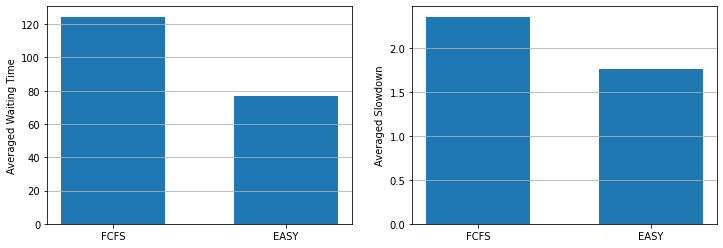

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read results
fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
fcfs['name'], easy['name'] = "FCFS", "EASY"
benchmark = pd.concat([fcfs, easy], ignore_index=True)

# Waiting time
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Averaged Waiting Time")

# Slowdown
plt.subplot(1, 2, 2)
plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Averaged Slowdown")

# Show
plt.show()

Considering the averaged waiting time and slowdown, the EASY scheduler achieved by far the best performance. By implementing the backfilling mechanism we were able to considerably minimize (on average) both the waiting time and slowdown of the jobs. 

To better understand where these gains come from, we can use the [evalys package](https://pypi.org/project/evalys/) to plot a Gantt chart:

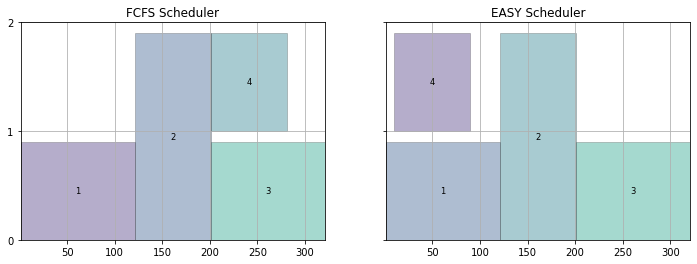

In [5]:
from evalys.jobset import JobSet
from evalys.visu.legacy import plot_gantt
    
# Convert monitors to dataframes
fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

# Load dataframes into JobSet objects.
fcfs, easy = JobSet(fcfs), JobSet(easy)

# Plot gantts
_, ax_list = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
plot_gantt(fcfs, ax=ax_list[0], title="FCFS Scheduler")
plot_gantt(easy, ax=ax_list[1], title="EASY Scheduler")

# Show
plt.ylim(ymin=0, ymax=2)
plt.yticks([0, 1, 2]) # We have two hosts only.
plt.show()

Looking at the Gantt chart, we can observe the backfilling mechanism in action. The job ``w0!4`` was able to start before job ``w0!2`` without delaying it. Consequently, we achieved better waiting time and slowdown averages.

## Next Steps

This tutorial is a very simple example of how to evaluate scheduling policies. Neither the platform nor the workload were realistic. Moreover, we didn't consider the energy model. So, as the next steps, you can extend this tutorial to cover other policies, workloads, and platforms.